<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [1]:
%matplotlib inline

# Setup environment and collect initial data

In [77]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [78]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [79]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [ ]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [81]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

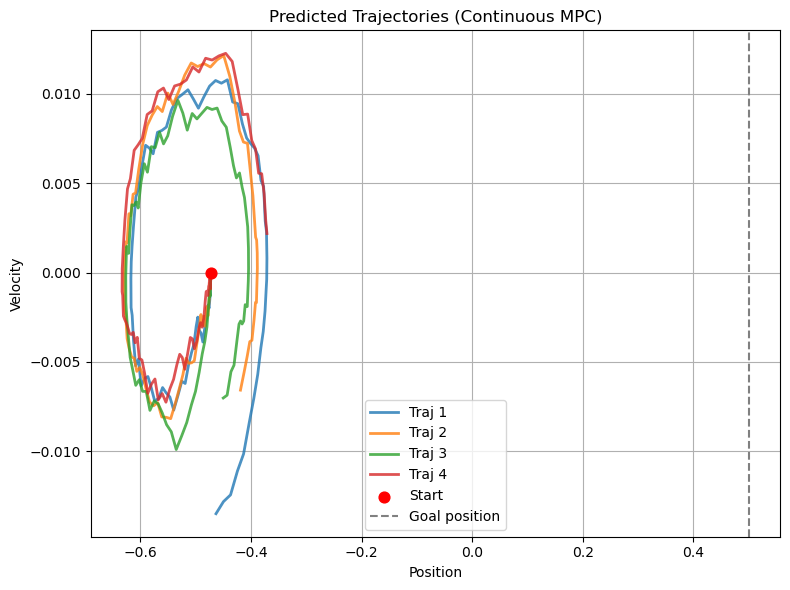

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#  MPC (Random Shooting)
# --------------------------------------------------------------

def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=5):
    """
    Random Shooting MPC for continuous actions in [-1, 1].
    Each GP predicts Δposition and Δvelocity given (pos, vel, action).
    """

    ########### TODO ####################
    # 1. Sample action sequences
    U = np.random.uniform(low=-1.0, high=1.0, size=(N_seq, H))

    # 2. Roll out trajectories
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3. Select top trajectories
    best_idx = np.argsort(J)[:plot_best]   # indices of lowest-cost trajectories
    best_seq = U[best_idx[0]]              # best single sequence (lowest cost)

    # Plot the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_idx]
        plot_trajectories(state, best_traj)

    # 4. Return the first action of the best sequence
    best_action = best_seq[0]
    return best_action


obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [ ]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.43734595  0.        ] a= 0.29882457295611564
t= 10 state= [-0.49775577 -0.01231307] a= -0.2895218625531082
t= 20 state= [-0.6311491  -0.01376132] a= -0.7155891853918557
t= 30 state= [-0.7418218  -0.00610048] a= 0.561715512883562
t= 40 state= [-0.69129056  0.01496725] a= -0.16969592611049467
t= 50 state= [-0.4661562   0.02651944] a= 0.27336343764263393
t= 60 state= [-0.23987123  0.0172512 ] a= -0.3737416827337272
t= 70 state= [-0.18485984 -0.00612554] a= -0.9834921304624065
t= 80 state= [-0.3796452 -0.0309355] a= -0.8856221831543545
t= 90 state= [-0.744792   -0.03747366] a= -0.15583520293654618
t= 100 state= [-1.0169578  -0.01918177] a= 0.7965350189829661
t= 110 state= [-1.0640229   0.00715557] a= -0.19858874417193428
t= 120 state= [-0.8280587   0.03589575] a= -0.492405954682829
t= 130 state= [-0.37409022  0.04878793] a= -0.4879577224113647
t= 140 state= [0.00121648 0.02558725] a= -0.99789846399987
t= 150 state= [0.11296721 0.00114075] a= -0.7080884707193078
t= 160 state

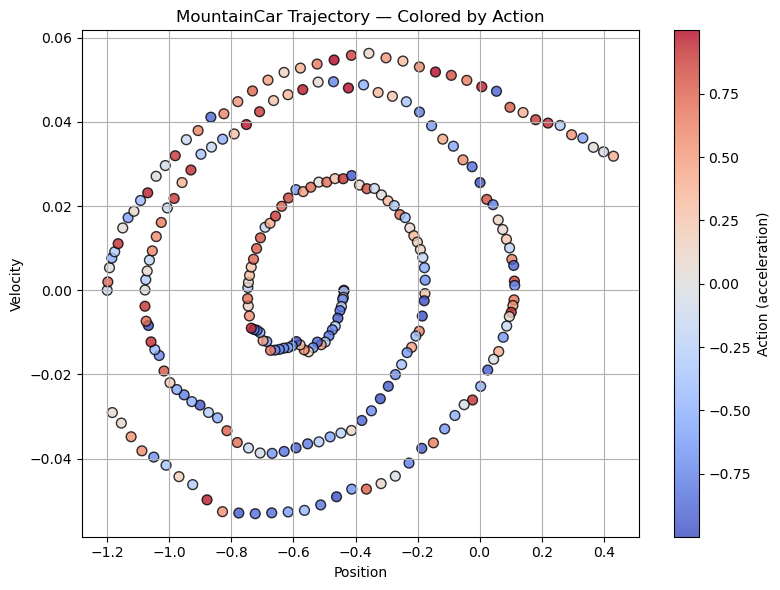

In [112]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(trajectory)

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

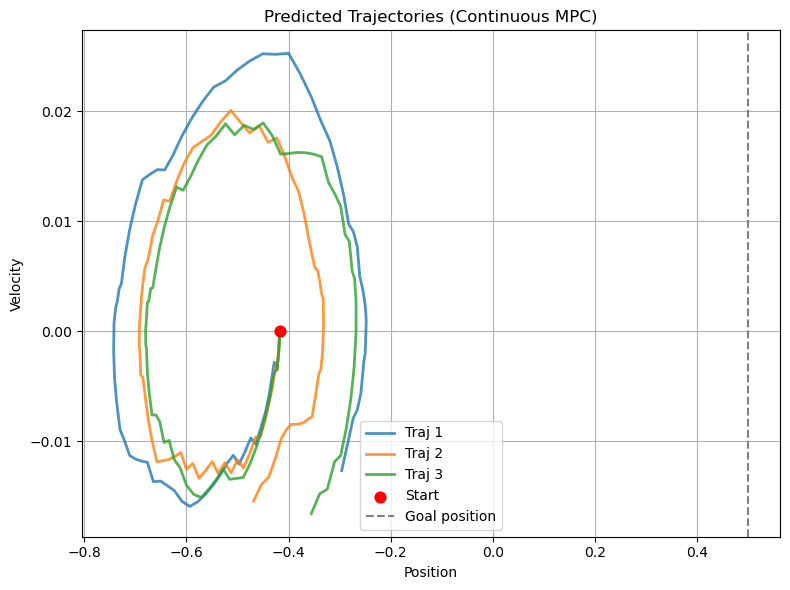

np.float64(1.0)

In [113]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0  # last action set to zero

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        U = self.U_mean + noise
        U = np.clip(U, -1.0, 1.0)

        # 2. Roll out trajectories
        all_traj, J = roll_out_n_trajectories(state, U)

        # 3. Select the best trajectory (lowest cost)
        best_k = np.argmin(J)
        best_seq = U[best_k]
        best_action = best_seq[0]

        self.U_mean = best_seq.copy() # Update mean sequence with the best one (persistent planning)

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        # best_action = ????
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [114]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.1480239102021113
10 [-0.498812   -0.00861914] -1.0
20 [-0.6507013  -0.01875879] -1.0
30 [-0.8281681  -0.01098376] 1.0
40 [-0.75124276  0.02233267] 0.6955943591935898
50 [-0.40607652  0.04115583] 1.0
60 [0.00045399 0.03749415] 0.7902031588252562
70 [0.32519177 0.03028423] 1.0
Total time: 74


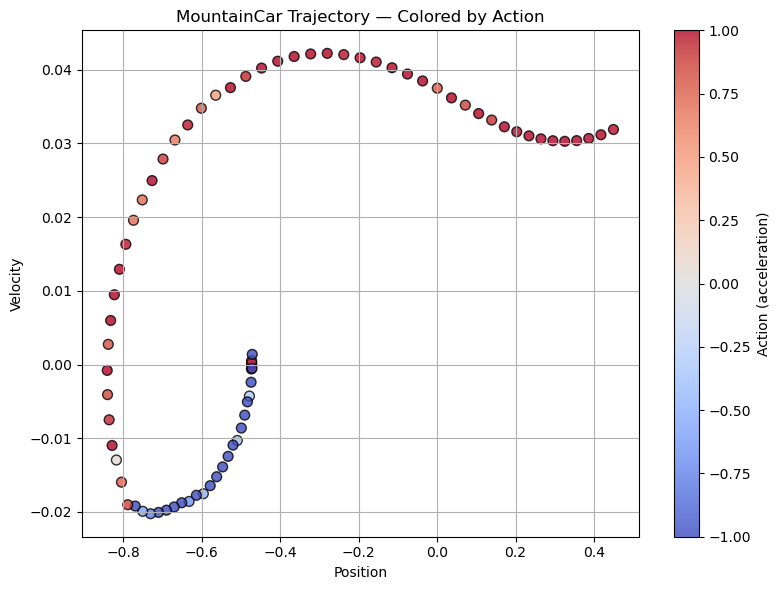

Energy 62.20665634598039


In [115]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?


### part A -  Stop-at-goal

In [64]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 🏔️ Mountain Car Environment
# ============================================================
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

# ============================================================
# 🔧 Mountain Car Dynamics
# ============================================================
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# ============================================================
# 💰 Cost functions (for MPC/MPPI using cost = -reward)
# ============================================================
# def cost_stop_goal(state, a):
#     x, v = state
#     x_goal = 0.45
#     w_p = 100.0     # posición (importancia alta)
#     w_v = -100.0      # velocidad (menor que posición)
#     w_u = 0.0       # penalización de control
#     cost = w_p * (x - x_goal)**2 + w_v * (np.abs(v)) + w_u * (a**2)
#     return cost

# def cost_energy_saving(state, a):
#     x, v = state
#     x_goal = 0.45
#     w_p = 100.0
#     w_v = 10.0
#     w_u = 5.0       # energía muy costosa
#     cost = w_p * (x - x_goal)**2 + w_v * (v**2) + w_u * (a**2)
#     return cost

# def cost_fn(state, a):
#     return cost_stop_goal(state, a) + cost_stop_goal(state, a)


# def ultimate_cost_stop_goal(state, a):
#     x, v = state
#     x_goal = 0.45
#     w_p = 1.0     # posición (importancia alta)
#     w_v = -1000.0      # velocidad (menor que posición)
#     w_u = 0.0       # penalización de control
#     def cn_func(x,x_goal):
#         if x < x_goal:
#             return 1
#         else:
#             return 0
#     cost = w_p * (x - x_goal)**2 + w_v * cn_func(x,x_goal) * (np.abs(v)) + w_u * (a**2)
#     print(w_v * cn_func(x,x_goal))
#     return cost


def ultimate_cost_stop_goal(state, a):
    x, v = state
    x_goal = 0.45
    w_p = 100.0     # posición (importancia alta)
    w_v = -1000.0      # velocidad (menor que posición)
    w_u = 1.0       # penalización de control

    def sigmoid(x):
        return 1/(1+np.exp(-40*(0.62-x)))

    cost = w_p * (x - x_goal)**2 + w_v * sigmoid(x) * (np.abs(v)) + w_u * (a**2)
    # print(str(w_v * sigmoid(x)) + " at position " + str(x))
    return cost



def cost_fn(state, a):
    return ultimate_cost_stop_goal(state, a)





In [65]:

# # ============================================================
# # 📈 Rollout Functions
# # ============================================================
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj




array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [66]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

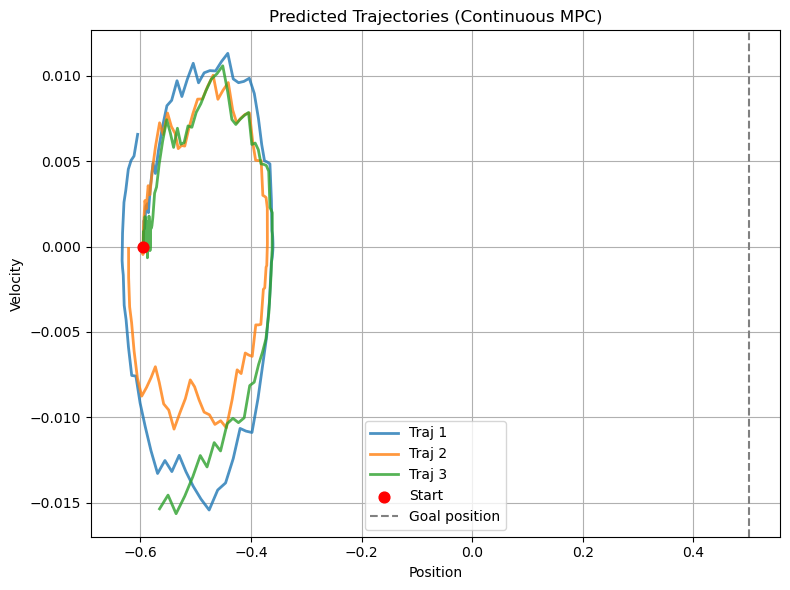

np.float64(1.0)

In [67]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)
        self.U_mean = np.roll(self.U_mean, -1)
        self.U_mean[-1] = 0.0  # last action set to zero

        # 1. Sample action sequences (Gaussian noise around previous U_mean)
        noise = np.random.normal(0, σ, size=(N_seq, H))
        U = self.U_mean + noise
        U = np.clip(U, -1.0, 1.0)

        # 2. Roll out trajectories
        all_traj, J = roll_out_n_trajectories(state, U)

        # 3. Select the best trajectory (lowest cost)
        best_k = np.argmin(J)
        best_seq = U[best_k]
        best_action = best_seq[0]

        self.U_mean = best_seq.copy() # Update mean sequence with the best one (persistent planning)

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        # best_action = ????
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [68]:
# Initialize controller once
mppi = MPPIController(H=100, N_seq=400, λ=.10, σ=3.0)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if trunc or obs[0]>=0.6: #term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] 0.41985546437756416
10 [-4.7184676e-01  2.3477078e-04] 1.0
20 [-0.45148015  0.00180962] 1.0
30 [-0.5043676  -0.01287391] -0.28812082130736255
40 [-0.6618308  -0.01638129] -0.057594279705627915
50 [-0.74576384  0.0018523 ] 1.0
60 [-0.60427856  0.01857791] 1.0
70 [-0.36329922  0.02532838] -1.0
80 [-0.169958    0.01411786] 1.0
90 [-0.12044622 -0.00335581] -1.0
100 [-0.2773655  -0.02233887] -1.0
110 [-0.62790537 -0.04044002] -1.0
120 [-0.9868863  -0.02800178] -1.0
130 [-1.0946001   0.00151783] 1.0
140 [-0.9014567   0.03315167] 1.0
150 [-0.45202658  0.0499939 ] -0.007693786109608247
160 [-0.01097569  0.038893  ] 1.0
170 [0.25544694 0.01735416] 1.0
180 [0.39502347 0.01141393] -1.0
190 [0.4517905  0.00408151] -0.654293229345154
200 [4.8169714e-01 2.7209675e-04] 1.0
210 [0.4905172  0.00168517] -1.0
220 [ 0.49922487 -0.00050573] -0.19067560412468065
230 [0.5170061 0.0022368] 1.0
240 [0.54268205 0.00198808] -1.0
250 [ 0.53859764 -0.00410271] 1.0
260 [0.54008347 0.0025

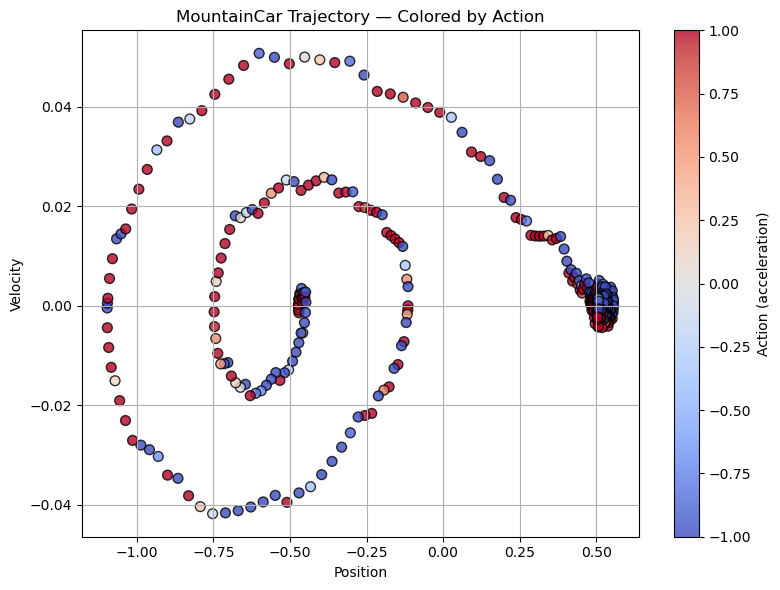

Energy 426.4805916916742


In [69]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]

def plot_trajectory(trajectory):
    positions, velocities, actions = [], [], []

    for entry in trajectory:
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))  # ensure scalar

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    # --------------------------------------------------------------
    # Scatter plot: position vs velocity, colored by action
    # --------------------------------------------------------------
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=50, edgecolor='k', alpha=0.8)

    cbar = plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory — Colored by Action")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

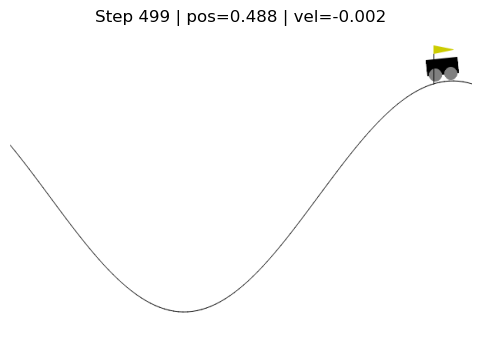

✅ Simulación terminada.


In [70]:
# ======================================
# Simulación con render y almacenamiento
# ======================================
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
obs, _ = env.reset(seed=0)
controller = MPPIController(H=80, N_seq=300, λ=10.0, σ=3.0)

positions, velocities, actions = [], [], []

fig, ax = plt.subplots(figsize=(6, 4))
frame = env.render()
img = ax.imshow(frame)
ax.axis("off")
display(fig)

done, step = False, 0

while not done and step < 500:
    a_scalar = controller.action(obs)
    a = np.array([a_scalar], dtype=np.float32)

    obs, r, terminated, truncated, _ = env.step(a)
    done = truncated # terminated or truncated

    positions.append(obs[0])
    velocities.append(obs[1])
    actions.append(a_scalar)

    # Mostrar entorno
    frame = env.render()
    img.set_data(frame)
    ax.set_title(f"Step {step} | pos={obs[0]:.3f} | vel={obs[1]:.3f}")
    clear_output(wait=True)
    display(fig)
    plt.pause(0.001)

    step += 1

env.close()
plt.close(fig)

print("✅ Simulación terminada.")

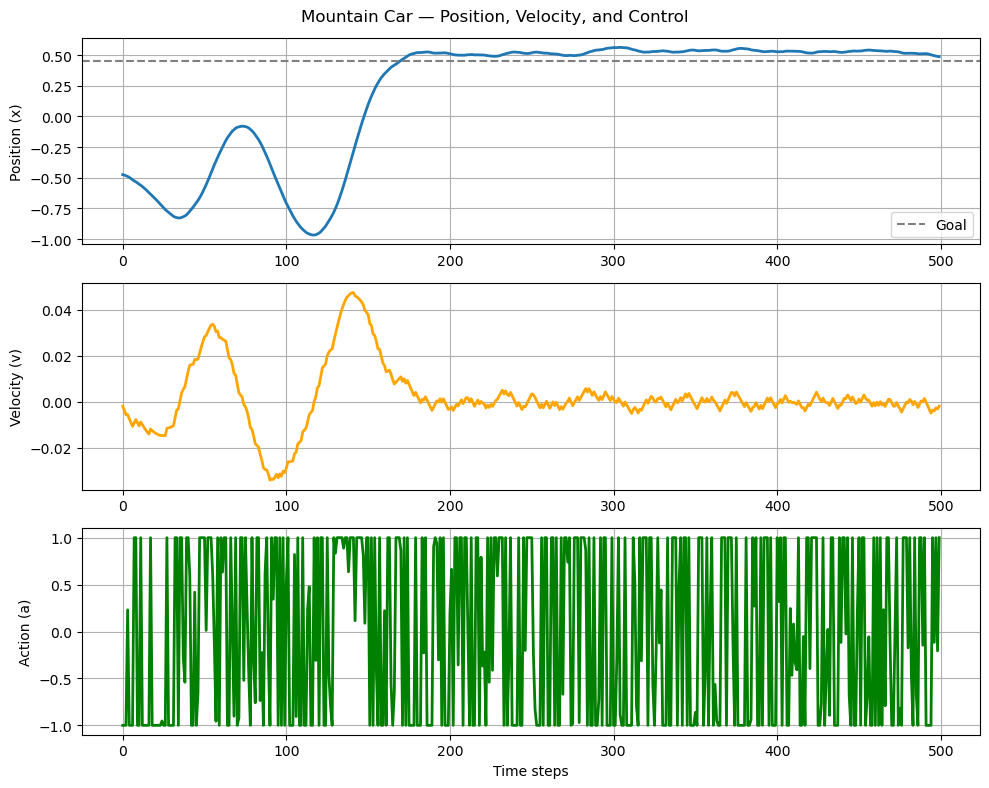

In [71]:
# ======================================
# 📊 Position, Velocity, and Control Plot
# ======================================
t = np.arange(len(positions))

plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.plot(t, positions, lw=2)
plt.axhline(0.45, color='gray', ls='--', label='Goal')
plt.ylabel("Position (x)")
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, velocities, lw=2, color='orange')
plt.ylabel("Velocity (v)")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, actions, lw=2, color='green')
plt.ylabel("Action (a)")
plt.xlabel("Time steps")
plt.grid(True)

plt.suptitle("Mountain Car — Position, Velocity, and Control")
plt.tight_layout()
plt.show()

### part B -  Energy saving

In [125]:
def ultimate_cost_stop_goal(state, a):
    x, v = state
    x_goal = 0.45
    w_p = 1.0     # posición (importancia alta)
    w_v = -1000.0      # velocidad (menor que posición)
    w_u = 100.0       # penalización de control

    def sigmoid(x):
        return 1/(1+np.exp(-40*(0.8-x)))

    cost = w_p * (x - x_goal)**2 + w_v * sigmoid(x) * (np.abs(v)) + w_u * (a**2)
    # print(str(w_v * sigmoid(x)) + " at position " + str(x))
    return cost


def cost_energy_saving(state, a):
    x, v = state
    x_goal = 0.45
    w_p = 100.0
    w_v = -1000.0
    w_u = 1.0       # energía muy costosa
    cost = w_p * (x - x_goal)**2 + w_v * (v**2) + w_u * (a**2)
    return cost



def cost_fn(state, a):
    return cost_energy_saving(state, a)




In [126]:
# Initialize controller once
mppi = MPPIController(H=100, N_seq=400, λ=.10, σ=3.0)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if trunc or obs[0]>=0.6: #term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] 1.0
10 [-0.4670879   0.00106041] 1.0
20 [-0.4244559   0.00597583] 1.0
30 [-0.37297714  0.00320442] 0.36359525679206306
40 [-0.3620867 -0.0032885] 0.45357388838149126
50 [-0.42458194 -0.0079073 ] 1.0
60 [-0.50313205 -0.00693019] 0.4289639401510015
70 [-0.5449091  -0.00374096] 1.0
80 [-0.5256962   0.00667153] 1.0
90 [-0.43141904  0.00894946] 0.3199808628642621
100 [-0.3302481   0.01042626] 1.0
110 [-0.24989934  0.00312566] 0.6260901843303169
120 [-0.24936554 -0.00273429] -0.554883314361799
130 [-0.36441475 -0.01931615] -0.43134290498502037
140 [-0.6373226  -0.03310939] -1.0
150 [-0.9229706  -0.02219113] 1.0
160 [-1.0376029  -0.00327944] 1.0
170 [-0.9095993   0.02305362] 1.0
180 [-0.55546147  0.04272634] -1.0
190 [-0.19598746  0.02696456] -1.0
200 [-0.06964588  0.00084515] -1.0
210 [-0.22295794 -0.03041632] -1.0
220 [-0.63445467 -0.04202553] 1.0
230 [-0.98129326 -0.02384383] -1.0
240 [-1.0908135e+00  2.1148511e-04] 0.801844773069725
250 [-0.91134936  0.03468569

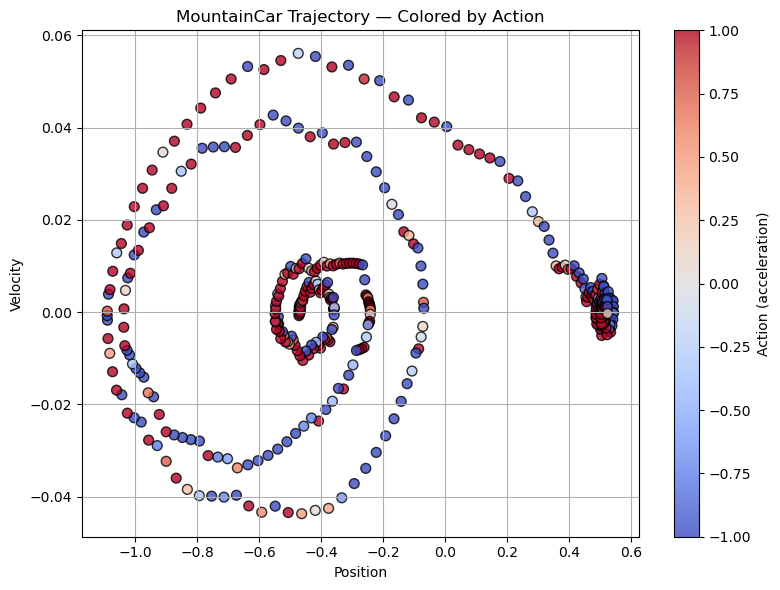

Energy 405.7327934287756


In [127]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

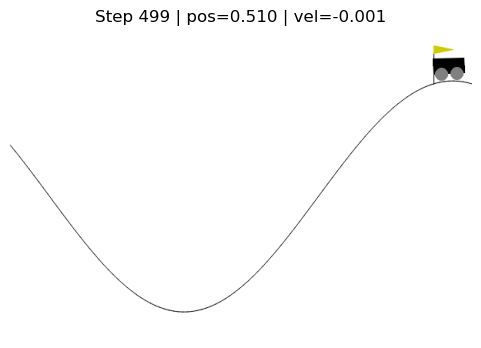

✅ Simulación terminada.


In [132]:
# ======================================
# Simulación con render y almacenamiento
# ======================================
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
obs, _ = env.reset(seed=0)
controller = MPPIController(H=100, N_seq=400, λ=10.0, σ=3.0)

positions, velocities, actions = [], [], []

fig, ax = plt.subplots(figsize=(6, 4))
frame = env.render()
img = ax.imshow(frame)
ax.axis("off")
display(fig)

done, step = False, 0

while not done and step < 500:
    a_scalar = controller.action(obs)
    a = np.array([a_scalar], dtype=np.float32)

    obs, r, terminated, truncated, _ = env.step(a)
    done = truncated # terminated or truncated

    positions.append(obs[0])
    velocities.append(obs[1])
    actions.append(a_scalar)

    # Mostrar entorno
    frame = env.render()
    img.set_data(frame)
    ax.set_title(f"Step {step} | pos={obs[0]:.3f} | vel={obs[1]:.3f}")
    clear_output(wait=True)
    display(fig)
    plt.pause(0.001)

    step += 1

env.close()
plt.close(fig)

print("✅ Simulación terminada.")

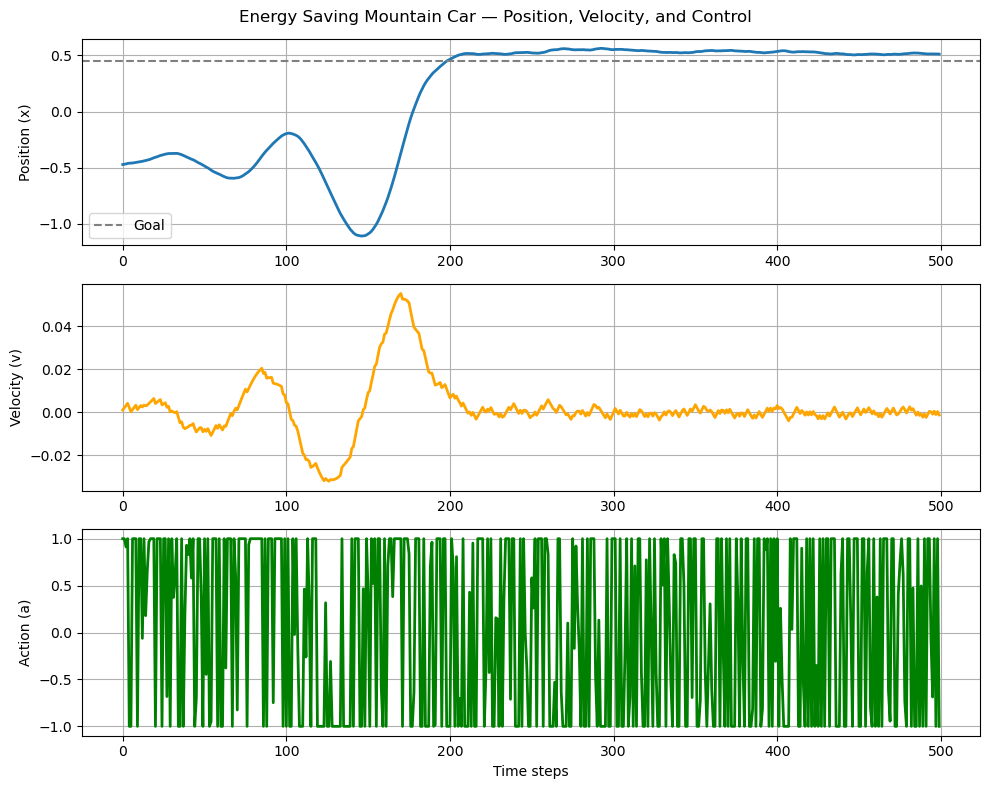

In [134]:
# ======================================
# 📊 Position, Velocity, and Control Plot
# ======================================
t = np.arange(len(positions))

plt.figure(figsize=(10, 8))

plt.subplot(3,1,1)
plt.plot(t, positions, lw=2)
plt.axhline(0.45, color='gray', ls='--', label='Goal')
plt.ylabel("Position (x)")
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, velocities, lw=2, color='orange')
plt.ylabel("Velocity (v)")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, actions, lw=2, color='green')
plt.ylabel("Action (a)")
plt.xlabel("Time steps")
plt.grid(True)

plt.suptitle("Energy Saving Mountain Car — Position, Velocity, and Control")
plt.tight_layout()
plt.show()

### Short report

(a) Stop-at-goal reward:

The first reward function, designed to make the car stop at the top, penalized both the distance from the goal position and the velocity near the target (x ≈ 0.45). During simulation, this reward caused the car to reach the hilltop more purposefully and reduce its speed as it approached the goal. The position term was the most influential in driving the car upward, while the velocity penalty helped damp out oscillations once it arrived. As a result, the car successfully reached the goal and slowed down smoothly, showing only minor residual vibrations instead of overshooting or bouncing around the top.

(b) Energy-saving reward:

In the second reward version, focused on energy efficiency, the distance penalty was retained but the weight on the control-effort term (a²) was increased. This encouraged smaller actions and smoother acceleration. The energy term became the dominant factor, leading to a slower but more stable climb. The car used less control effort overall, with reduced velocity peaks and a longer time to reach the hilltop. In most cases, it approached the goal gently and stopped smoothly, although in some trials it failed to fully reach the top due to the conservative control strategy imposed by the stronger energy penalty.